Airbnb data exploration, analysis and feature engineering aims to develop a foundation to perform an analysis of the data presented by Airbnb. It demonstrates how to formulate scrapped data into features that will assist the model to predict the listing’s price.
Airbnb, Inc. is an American vacation rental online marketplace company. Airbnb maintains and hosts a marketplace, accessible to consumers on its website or via an app.

#### 1. Data acquisition

The platform hosts updated data of the Airbnb listings. Data from any desired location can be used for this project, however, this analysis has been performed on Cape Towns’s data. Data from multiple locations can be used as well and can be merged using pandas.


#### 2. Data preprocessing

To utilize the data effectively, relevant data preprocessing techniques must be applied.
As a part of this preprocessing following actions were performed:

   * Converting date to pandas DateTime format
   * Removing currency symbols from price and converting it to a continuous data type Float, will later assist the model to predict continuous values
   * Removing the % symbols for some features and convert them to integers
   * Removing outliers, this step is essentially performed to make sure that abnormalities present in data may not reciprocate in our statistics and modelling:
    
#### 3. Feature engineering

To further enhance the feature set, some of the columns needs to be parsed, for example, the ‘host_verifications’ and ‘amenities’ column can be further processed and parsed to be used as an effective source of information. As a sample, here is the column of amenities and host verifications containg default scrapped values:

Additionally, like host verifications feature, the data contains some other features describing the host further. One such field is ‘host_since’, this is the date when the ad poster joined the platform. By calculating the number of days host has been on the platform, we can enhace the features. Lets see going further of that affects the model at all when we perform evaluation.

#### 4. Statistical analysis

Following is the distribution of frequency of listings throughout the year of 2022:

Figure shows the average price of listings throughout the year. It has a calculated weekly average of the number of ads posted on the platform.

Now let’s see if there exists a correlation between the number of listings published in a time frame and their average price:

Figure shows the correlation between the number of listings and average price. As the number of listings rise, the average price of the listings rises proportionally.

Moving on, Cape Town, being a huge tourist destination, let us visualise the impact of different neighbourhoods present in the city on the listing price:

#### 5. Model training

After the preprocessing, feature engineering and encoding the data into respective formats, we split the data in train and validation set like any other regression problem.

For the purpose of this project, we use XGBoost as our model. Please note that the purpose of this experiment is not to achieve the highest accuracy, but to build a pipeline and critical thinking for the problem. The models can be replaced with different parameters or model:

#### 6. Model evaluation

In [1]:
import pandas as pd

import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')


#### Calendar Data.

In [2]:
#Calendar data to a pandas 'calendar dataframe'
calendar_url = 'http://data.insideairbnb.com/south-africa/wc/cape-town/2021-12-25/data/calendar.csv.gz'
calendar = pd.read_csv(calendar_url)

print('We have', calendar.date.nunique(), 'days and', calendar.listing_id.nunique(), 'unique listings in the calendar data.')

We have 369 days and 17305 unique listings in the calendar data.


In [3]:
calendar.date.min(), calendar.date.max()

('2021-12-25', '2022-12-28')

The calendar covers one year time frame, that is, price and availability every day for the next one year. In our case, from 2021–12–25 to 2022–12–28.

In [4]:
calendar.isnull().sum()

listing_id          0
date                0
available           0
price             194
adjusted_price    194
minimum_nights      6
maximum_nights      6
dtype: int64

there are 194 listings with missing price values

In [5]:
calendar.shape

(6316263, 7)

In [6]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3191,2021-12-25,f,$468.00,$468.00,3.0,730.0
1,1295788,2021-12-26,f,$750.00,$750.00,2.0,1125.0
2,1295788,2021-12-27,f,$750.00,$750.00,2.0,1125.0
3,1295788,2021-12-28,f,$750.00,$750.00,2.0,1125.0
4,1295788,2021-12-29,f,$750.00,$750.00,2.0,1125.0


In [7]:
calendar.available.value_counts()

t    3948858
f    2367405
Name: available, dtype: int64

f (false) means not available, t(true) means available.

Find out daily average availability for one year. Convert available column to 0 if available and 1 if not.


In [8]:
calendar_new = calendar[['date', 'available']]
calendar_new['busy'] = calendar_new.available.map( lambda x: 0 if x == 't' else 1)
calendar_new = calendar_new.groupby('date')['busy'].mean().reset_index()
calendar_new['date'] = pd.to_datetime(calendar_new['date'])

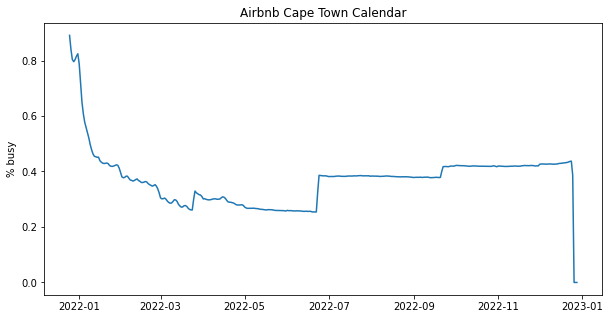

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb Cape Town Calendar')
plt.ylabel('% busy')
plt.show();

As expected, January was the busiest month for Cape Town Airbnb.

In [10]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3191,2021-12-25,f,$468.00,$468.00,3.0,730.0
1,1295788,2021-12-26,f,$750.00,$750.00,2.0,1125.0
2,1295788,2021-12-27,f,$750.00,$750.00,2.0,1125.0
3,1295788,2021-12-28,f,$750.00,$750.00,2.0,1125.0
4,1295788,2021-12-29,f,$750.00,$750.00,2.0,1125.0


#### Price on the Calendar

How prices change over the year by month?

Remove "$" symbol in price column and convert it to numeric, and convert date to datetime data type.

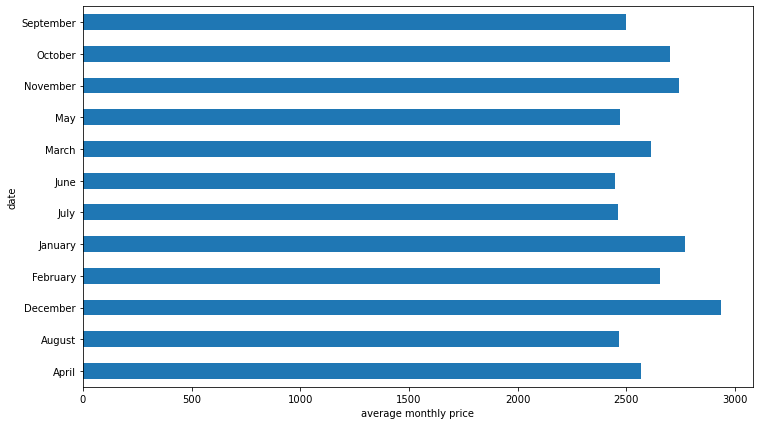

In [11]:
#removes special characters
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['price'] = calendar['price'].str.replace(',', '')
calendar['price'] = calendar['price'].str.replace(' ', '')
calendar['price'] = calendar['price'].str.replace('$', '')
calendar['price'] = calendar['price'].astype(float)
calendar['date'] = pd.to_datetime(calendar['date'])

#impute price missing values with mean.
calendar['price'].fillna(value= calendar['price'].mean(), inplace = True)

mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'),
                                 sort=True)['price'].mean()
mean_of_month.plot(kind = 'barh' , figsize = (12,7))

plt.xlabel('average monthly price');

The Airbnb price in Cape Town is highest in the months of october upto January. These three months are the best months for visiting Cape town because its usually summer.

#### How price changes during day of week?


In [12]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3191,2021-12-25,f,468.0,$468.00,3.0,730.0
1,1295788,2021-12-26,f,750.0,$750.00,2.0,1125.0
2,1295788,2021-12-27,f,750.0,$750.00,2.0,1125.0
3,1295788,2021-12-28,f,750.0,$750.00,2.0,1125.0
4,1295788,2021-12-29,f,750.0,$750.00,2.0,1125.0


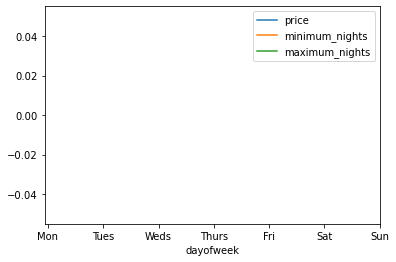

In [13]:


calendar['dayofweek'] = calendar.date.dt.day_name
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
price_week=calendar[['dayofweek','price']]
price_week = calendar.groupby(['dayofweek']).mean().reindex(cats)
price_week.drop('listing_id', axis=1, inplace=True)
price_week.plot()
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels);

**Code not working to reflect price on y axis, looking for solutions**

### Listings

Number of listings in each neighbourhood.

In [14]:
#Listings data to a pandas 'listings dataframe'
listing_url = 'http://data.insideairbnb.com/south-africa/wc/cape-town/2021-12-25/data/listings.csv.gz'
listings = pd.read_csv(listing_url)

print('We have', listings.id.nunique(), 'listings in the listing data.')



We have 17305 listings in the listing data.


In [15]:
listings.isnull().sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               0
                                                ... 
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               4824
Length: 74, dtype: int64

In [16]:
listings.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

,id
neighbourhood_cleansed,
Ward 115,3232
Ward 54,2294
Ward 77,1084
Ward 23,980
Ward 74,837
Ward 64,832
Ward 61,758
Ward 62,506
Ward 59,454


The neighbourhood that has the highest number of listings is Ward 115. From map at Inside Airbnb, we can see that too.

#### Review score rating

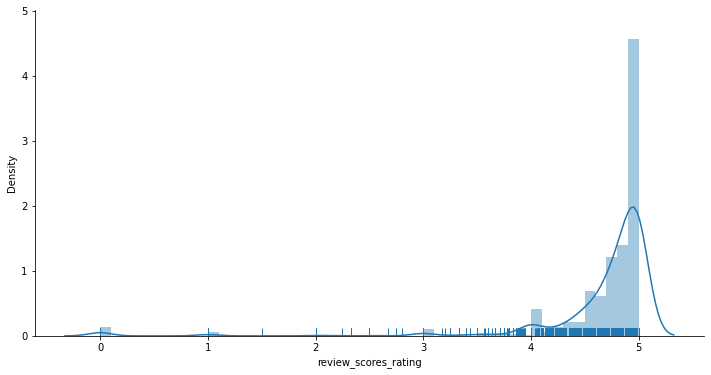

In [17]:
plt.figure(figsize=(12,6))
sns.distplot(listings.review_scores_rating.dropna(), rug=True)
sns.despine()
plt.show();



as expected most reviews are 5 stars

In [18]:
listings.review_scores_rating.describe()


count    12481.000000
mean         4.665367
std          0.718618
min          0.000000
25%          4.670000
50%          4.870000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64

As expected, most of reviewers leave high scores.

#### Exploring the price.

In [19]:
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].astype(float)

#fill any missing values with mean
listings['price'].fillna(value= listings['price'].mean(), inplace = True)

listings['price'].describe()

count     17305.000000
mean       3045.825542
std        6901.533651
min         144.000000
25%         790.000000
50%        1414.000000
75%        2857.000000
max      200000.000000
Name: price, dtype: float64

The most expensive Airbnb listing in capetown costs 200,000.

In [20]:
import numpy as np

listings.iloc[np.argmax(listings['price'])]

id                                                                           53349114
listing_url                                     https://www.airbnb.com/rooms/53349114
scrape_id                                                              20211225071136
last_scraped                                                               2021-12-25
name                                                                      Family room
                                                                ...                  
calculated_host_listings_count                                                      1
calculated_host_listings_count_entire_homes                                         0
calculated_host_listings_count_private_rooms                                        1
calculated_host_listings_count_shared_rooms                                         0
reviews_per_month                                                                 NaN
Name: 16576, Length: 74, dtype: object

### Price Distribution.

Text(0.5, 1.0, 'Histogram of listing prices')

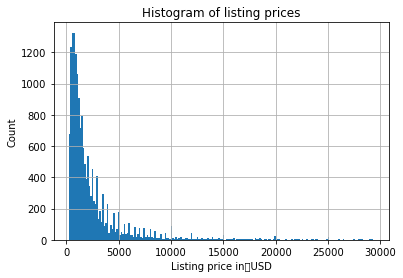

In [21]:
listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))].price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in　USD')
plt.title('Histogram of listing prices')

#### Removing outliers in price and those with 0

In [22]:
listings.loc[listings['price'] > listings['price'].quantile(0.99)]['price'].describe()

count       174.000000
mean      52751.971264
std       32873.348371
min       29500.000000
25%       35000.000000
50%       40428.500000
75%       55000.000000
max      200000.000000
Name: price, dtype: float64

In [23]:
listings.loc[listings['price'] > listings['price'].quantile(0.99)]['price'].count()

174

In [24]:
listings.loc[listings['price'] < listings['price'].quantile(0.01)]['price'].count()

166

Listings price after removing outliers

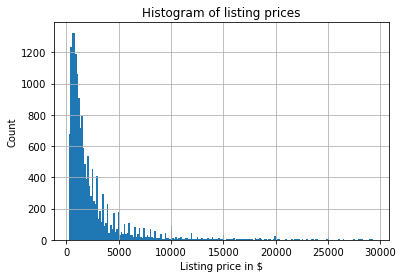

In [25]:
listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))].price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('Histogram of listing prices');

#### Neighbourhood vs. Price

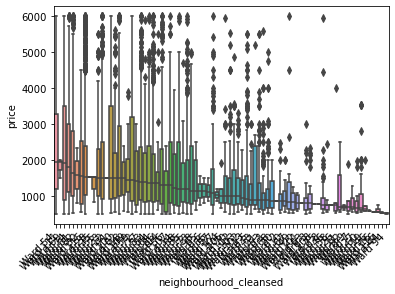

In [26]:
sort_price = listings.loc[(listings.price <= listings['price'].quantile(0.90)) & (listings.price > listings['price'].quantile(0.1))]\
                    .groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=listings.loc[(listings.price <= listings['price'].quantile(0.9)) & (listings.price > listings['price'].quantile(0.1))], 
            order=sort_price)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Ward 115 has the highest number of listings and ward 54 has the lowest median price.

#### Host vs. price

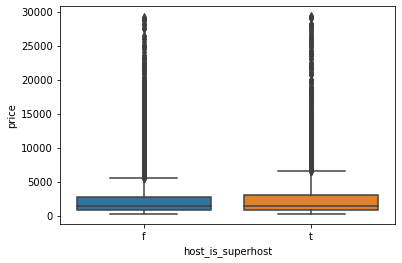

In [27]:
sns.boxplot(y='price', x='host_is_superhost', data=listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))])

plt.show();



Super host does enjoy a little higher median price than normal host.


#### property type vs. price

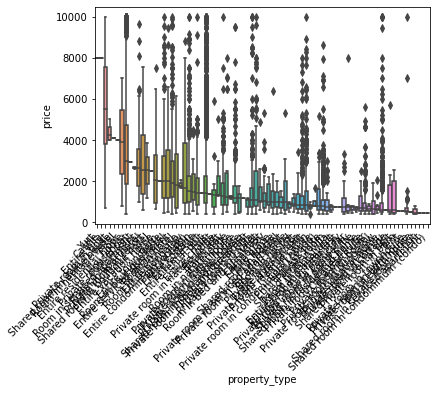

In [28]:
sort_price = listings.loc[(listings.price <= listings['price'].quantile(0.95)) & (listings.price > listings['price'].quantile(0.05))]\
                    .groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='property_type', data=listings.loc[(listings.price <= listings['price'].quantile(0.95)) & (listings.price > listings['price'].quantile(0.05))], order=sort_price)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [29]:
listings.property_type.value_counts()

Entire rental unit                    5892
Entire residential home               3118
Private room in residential home      1352
Entire guest suite                     954
Entire villa                           735
                                      ... 
Entire resort                            1
Shared room                              1
Private room in lighthouse               1
Entire bed and breakfast                 1
Shared room in condominium (condo)       1
Name: property_type, Length: 88, dtype: int64

#### Room type vs. price

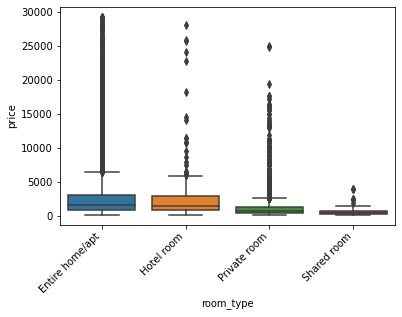

In [30]:
sort_price = listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))]\
                    .groupby('room_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='room_type', data=listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))], order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

This goes without saying, entire room/apt has a a much higher median price than the other room types.

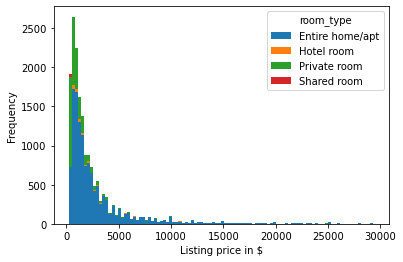

In [31]:
listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))].pivot(columns = 'room_type', values = 'price').plot.hist(stacked = True, bins=100)
plt.xlabel('Listing price in $');

Entire home/apt also has the most number of listings. Inside Airbnb has indicated that Entire homes or apartments highly available year-round for tourists, probably don't have the owner present, could be illegal, and more importantly, are displacing residents.

Private rooms at lower prices are also popular due to people prefering more privacy for the stays.

#### No. Accomondated vs. price

In [32]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17305 entries, 0 to 17304
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            17305 non-null  int64  
 1   listing_url                                   17305 non-null  object 
 2   scrape_id                                     17305 non-null  int64  
 3   last_scraped                                  17305 non-null  object 
 4   name                                          17305 non-null  object 
 5   description                                   16930 non-null  object 
 6   neighborhood_overview                         11370 non-null  object 
 7   picture_url                                   17305 non-null  object 
 8   host_id                                       17305 non-null  int64  
 9   host_url                                      17305 non-null 

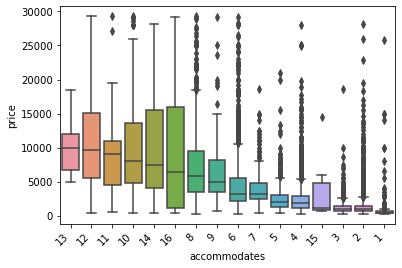

In [33]:
sort_price = listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))]\
                    .groupby('accommodates')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='accommodates', data=listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))], order=sort_price)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Properties that accomondate more people have a higher median price that those that accomondate fewer guests.

### Property type vs Price.

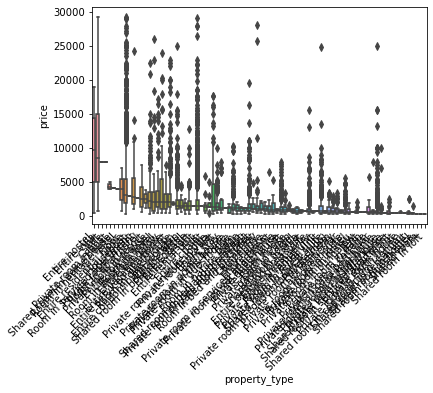

In [34]:
sort_price = listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))]\
                    .groupby('property_type')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='property_type', data=listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))], order=sort_price)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [35]:
listings.property_type.value_counts()

Entire rental unit                    5892
Entire residential home               3118
Private room in residential home      1352
Entire guest suite                     954
Entire villa                           735
                                      ... 
Entire resort                            1
Shared room                              1
Private room in lighthouse               1
Entire bed and breakfast                 1
Shared room in condominium (condo)       1
Name: property_type, Length: 88, dtype: int64

#### Amenities

The amenities text field needs some cleaning.


In [36]:
listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")

In [37]:
listings['amenities'].head()

0    [Hangers, Hot water, Free parking on premises,...
1    [Dishwasher, Hangers, Hot water, HDTV with Net...
2    [Dishwasher, Hangers, Hot water, Fire extingui...
3    [Elevator, Long term stays allowed, TV, Washer...
4    [Hangers, Hot water, Fire extinguisher, Backya...
Name: amenities, dtype: object


#### Top 20 most common amenities

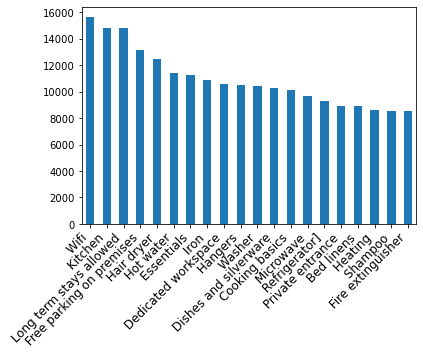

In [38]:
pd.Series(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(20)\
    .plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show();

Wifi, long term stays, kitchen and free parking etc are among the most common amenities.

#### Amenities vs. price top 20

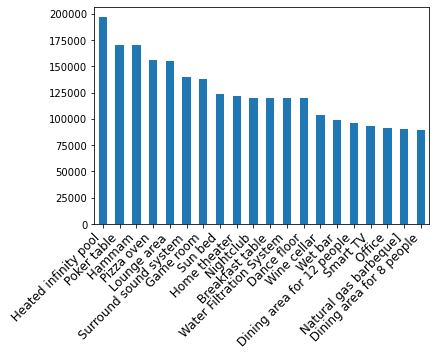

In [39]:
amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split(","))))

amenity_prices = [(amn, listings[listings['amenities'].map(lambda amns: amn in amns)]['price'].mean()) for amn in amenities if amn != ""]

amenity_srs = pd.Series(data=[a[1] for a in amenity_prices], index=[a[0] for a in amenity_prices])

amenity_srs.sort_values(ascending=False)[:20].plot(kind='bar')

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

plt.show();



Interesting, amenities features like infinity pool does seem to have some relationship with price.


#### Number of beds vs. price

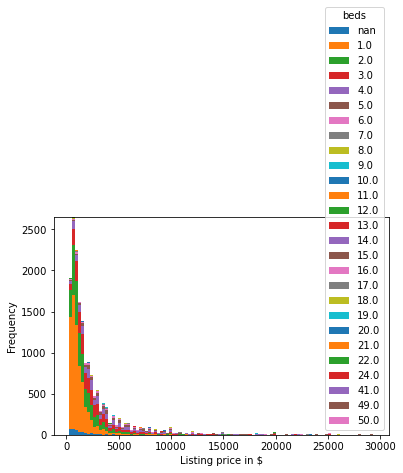

In [40]:
listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))].pivot(columns = 'beds',values = 'price').plot.hist(stacked = True,bins=100)

plt.xlabel('Listing price in $');

Vast majority of the listings have one bed, the one-bed listing prices have a very wide range. There are listings that have no bed.

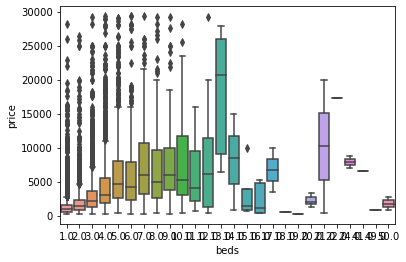

In [41]:
sns.boxplot(y='price', x='beds', data = listings.loc[(listings.price <= listings['price'].quantile(0.99)) & (listings.price > listings['price'].quantile(0.01))])
plt.show();



Interesting to discover that the median price for 13 bed listings is the highest, reason for this is because it can host more guests

### Modeling Listing Prices

Data preprocessing and feature engineering

In [44]:
listing_url = 'http://data.insideairbnb.com/south-africa/wc/cape-town/2021-12-25/data/listings.csv.gz'
listings = pd.read_csv(listing_url)



In [45]:
listings.price.isnull().sum()

0

Processing price feature. The feature we are going to model and predict.

In [46]:
listings['price'] = listings['price'].str.replace(',', '')
listings['price'] = listings['price'].str.replace('$', '')
listings['price'] = listings['price'].astype(float)

listings['price'].fillna(value= listings['price'].mean(), inplace = True)

listings = listings.loc[(listings.price <= listings['price'].quantile(0.95)) & (listings.price > listings['price'].quantile(0.05))]




##### Term document matrix for amenities feature.


In [47]:
listings.amenities = listings.amenities.str.replace("[{}]", "").str.replace('"', "")

listings.amenities.head()


0    [Hangers, Hot water, Free parking on premises,...
1    [Dishwasher, Hangers, Hot water, HDTV with Net...
2    [Dishwasher, Hangers, Hot water, Fire extingui...
3    [Elevator, Long term stays allowed, TV, Washer...
4    [Hangers, Hot water, Fire extinguisher, Backya...
Name: amenities, dtype: object

In [48]:


from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(listings['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop(1)





In [49]:
#Replace the values in the following feature to 0 if "f", to 1 if "t".

columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
            'instant_bookable','license','has_availability']
for c in columns:
    listings[c] = listings[c].replace('f',0,regex=True)
    listings[c] = listings[c].replace('t',1,regex=True)

##### The following are the numeric features we will be using.


In [50]:
listings_new = listings[['host_is_superhost', 'host_identity_verified','beds',
                         'instant_bookable','has_availability',
                         'host_listings_count', 'host_total_listings_count', 'minimum_nights',
                         'bedrooms', 'accommodates', 'number_of_reviews','review_scores_rating', 'price']]



##### Fill the missing values in the numeric features with median.


In [51]:


for col in listings_new.columns[listings_new.isnull().any()]:
    print(col)



host_is_superhost
host_identity_verified
beds
host_listings_count
host_total_listings_count
bedrooms
review_scores_rating


In [52]:
for col in listings_new.columns[listings_new.isnull().any()]:
    listings_new[col] = listings_new[col].fillna(listings_new[col].median())



In [53]:
listings_new.isnull().any()

host_is_superhost            False
host_identity_verified       False
beds                         False
instant_bookable             False
has_availability             False
host_listings_count          False
host_total_listings_count    False
minimum_nights               False
bedrooms                     False
accommodates                 False
number_of_reviews            False
review_scores_rating         False
price                        False
dtype: bool



#### Processing Categorical features


In [54]:
cat_feature = listings[[ 'property_type', 'room_type', 'neighbourhood_cleansed']]

In [55]:
for col in cat_feature.columns[cat_feature.isnull().any()]:
    print(col)

In [56]:
for cat_feature in ['property_type', 'room_type', 'neighbourhood_cleansed']:
    listings_new = pd.concat([listings_new, pd.get_dummies(listings[cat_feature])], axis=1)



##### Adding amenities feature


In [57]:
listings_new = pd.concat([listings_new, df_amenities], axis=1, join='inner')



##### Data preprocessing and feature engineering done!

## Modeling.

#### 1.  Random Forest Regressor.

In [58]:
print(pd.isnull(listings_new))

       host_is_superhost  host_identity_verified   beds  instant_bookable  \
0                  False                   False  False             False   
2                  False                   False  False             False   
3                  False                   False  False             False   
4                  False                   False  False             False   
5                  False                   False  False             False   
...                  ...                     ...    ...               ...   
15607              False                   False  False             False   
15608              False                   False  False             False   
15609              False                   False  False             False   
15610              False                   False  False             False   
15611              False                   False  False             False   

       has_availability  host_listings_count  host_total_listings_count  \


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


y = listings_new['price']


x = listings_new.drop('price', axis =1)

# Create instace
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)

rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)

#fit
rf.fit(X_train, y_train)

# Predict
y_train_pred = rf.predict(X_train)

#validate
y_test_pred = rf.predict(X_test)

rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

RMSE test: 1230.870
R^2 test: 0.591

Training r2: 0.9402
Validation r2: 0.591


### Evaluation.

Training set performance visualization

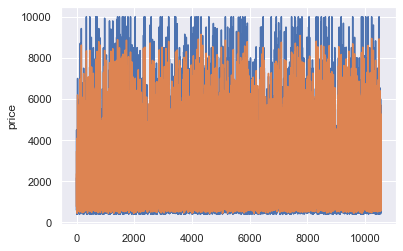

In [60]:


p = sns.lineplot(x=range(len(y_train)),y=y_train) # Blue

p = sns.lineplot(x=range(len(y_train_pred)),y=y_train_pred) # Orange



### Validation set performance visualization

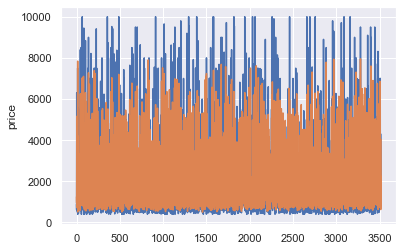

In [61]:


p = sns.lineplot(x=range(len(y_test)),y=y_test) # Blue

p = sns.lineplot(x=range(len(y_test_pred)),y=y_test_pred) # Orange




##### Feature importance of Random Forest

In [62]:
coefs_df = pd.DataFrame()

coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)


,est_int,coefs
9,accommodates,0.360300
143,Ward 54,0.056881
8,bedrooms,0.055753
11,review_scores_rating,0.028115
10,number_of_reviews,0.027087
7,minimum_nights,0.026858
5,host_listings_count,0.023532
112,Ward 115,0.023350
6,host_total_listings_count,0.023316
33,Entire villa,0.012289


In [1]:
#2. Logistic Regression
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression

#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_squared_error


#y = listings_new['price']
#x = listings_new.drop(('price'), axis = 1)

# Create instace
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=42)

#lr = LinearRegression()

#fit
#lr.fit(X_train, y_train)

# Predict
#predictions = lr.predict(X_train)

#validate
#val = lr.predict(X_test)

#mse = mean_squared_error(y_test,predictions)

#rmse_lr= np.sqrt(mse)

#print('RMSE test: %.3f' % rmse_lr)
#print('R^2 test: %.3f' % (r2_score(y_test, predictions)))


#print("\nTraining r2:", round(r2_score(y_train, val),4))
#print("Validation r2:", round(r2_score(y_test, predictions),4))